# Stability of 1ton Data

In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from datetime import timedelta, datetime

import re
import os
import sys
from scipy.optimize import curve_fit

from analysis_helper import *

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
         'axes.labelsize': 14,
         'axes.titlesize':14,}
pylab.rcParams.update(params)

In [3]:
"""
Needed for chi2 fitting
"""
def gauss(x, mu, sigma, N):
    """
    A gaussian function
    """
    arg = (x-mu)/sigma
    Norm=N*1/np.sqrt(2*np.pi)/sigma
    return Norm* np.exp(-0.5*arg*arg)

from scipy.stats import exponnorm, norm

def gaus_expo(x, mu, sigma, k, Ng, Ne):
    g = norm.pdf(x, loc=mu, scale=sigma)
    e = 1/k*np.exp(-k*x)
    return g*Ng + e*Ne

def calc_chi2(func, xdata, ydata, popt):
    """
    Pearson chi2
    """
    y = func(xdata, *popt)
    r = (y-ydata)/np.sqrt(ydata)
    r2 = np.square(r)
    return np.sum(r2)

def fit_gauss(h, fit_range, p0=[1, 1, 1]):
    """
    A function that fits binned data. It fits data twice.
    If covariance from the first fit is bad, do the second fit with smaller range
    
    Args:
        h: return of plt.hist
        fit_range: list of two float (ex. [1.0, 2.0] means fit range is from 1.0 to 2.0
    """
    ydata = h[0]
    xdata = (h[1][1:]+h[1][:-1])/2
    tot = np.trapz(ydata, xdata)
    p0[2]=tot
    bw = xdata[1]-xdata[0]
    # 1st fit
    fit_mask = (xdata>fit_range[0]) & (xdata<fit_range[1])
    sigma = np.sqrt(ydata[fit_mask])
    popt, pcov = curve_fit(gauss, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=p0)
    x = np.linspace(xdata[fit_mask][0], xdata[fit_mask][-1], 100)    
    y = gauss(x, popt[0], popt[1], 1)
    
    chi2 = calc_chi2(gauss, xdata[fit_mask], ydata[fit_mask], popt)
    dof = len(xdata[fit_mask])-2    
    err = np.diag(pcov)
    err = np.sqrt(err)
    
    return dict(
        x=x, 
        y=y*tot,
        popt=popt,
        chi2=chi2,
        dof=dof,
        err=err,
        nbin=len(xdata[fit_mask]),
    )

from scipy import special
def crystalball(x, mu, sigma, alpha, n, Norm):
    """
    https://en.wikipedia.org/wiki/Crystal_Ball_function
    x: float or numpy array
    par[0]: x mean
    par[1]: sigma
    par[2]: alpha
    par[3]: n
    """
    par=[mu, sigma, alpha, n]
    
    if par[2] == 0:
        print("Error: alpha cannot be 0 \n")
        return 0

    arg = (x - par[0]) / par[1]
    g_term = np.exp(-0.5 * arg * arg)

    arg2 = par[3] / abs(par[2])
    C = arg2 * 1 / (par[3] - 1) * np.exp(-par[2] * par[2] / 2)
    D = np.sqrt(np.pi / 2) * (1 + special.erf(abs(par[2]) / np.sqrt(2)))
    N = 1 / (C + D) / par[1]
    A = np.power(arg2, par[3]) * np.exp(-par[2] * par[2] / 2)
    B = arg2 - abs(par[2])

    # if input x is float
    if np.isscalar(x):
        if par[2] > 0:
            p_term = A * np.power(B - arg, -par[3])
            if arg > (-par[2]):
                return g_term * N * Norm
            else:
                return p_term * N * Norm
        else:
            p_term = A * np.power(B + arg, -par[3])
            if arg < (-par[2]):
                return g_term * N * Norm
            else:
                return p_term * N * Norm

    # otherwise treat x as numpy array
    if par[2] > 0:
        p_term = A * np.power(B - arg, -par[3])
        p_mask = np.logical_not(arg > (-par[2]))
        np.place(g_term, p_mask, p_term[p_mask])
        return g_term * N * Norm
    else:
        p_term = A * np.power(B + arg, -par[3])
        p_mask = np.logical_not(arg < (-par[2]))
        np.place(g_term, p_mask, p_term[p_mask])
        return g_term * N * Norm

def fit_crystalball(h, fit_range, p0=[1,1,1,1,1]):
    ydata = h[0]
    xdata = (h[1][1:]+h[1][:-1])/2
    bw = xdata[1]-xdata[0]
    fit_mask = (xdata>fit_range[0]) & (xdata<fit_range[1])
    sigma = np.sqrt(ydata[fit_mask])
    popt, pcov = curve_fit(crystalball, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=p0)
    x = np.linspace(xdata[fit_mask][0], xdata[fit_mask][-1], 100)    
    y = crystalball(x, popt[0], popt[1], popt[2], popt[3], popt[4])
    chi2 = calc_chi2(crystalball, xdata[fit_mask], ydata[fit_mask], popt)
    dof = len(xdata[fit_mask])-(len(popt)-1)
    err = np.diag(pcov)
    err = np.sqrt(err)
    return dict(
        x=x, 
        y=y,
        popt=popt,
        chi2=chi2,
        dof=dof,
        err=err,
        nbin=len(xdata[fit_mask]),
    )

def auto_fit_gauss(h, fit_range, p0=[1, 1, 1]):
    res = fit_gauss(h, fit_range, p0=p0)
    new_range = [res['popt'][0]-res['popt'][1], res['popt'][0]-res['popt'][1]]
    res = fit_gauss(h, new_range, p0=res['popt'])
    return res

def fit_expo_gauss(h, fit_range, p0=[1, 1, 1, 1]):
    """
    Expo modified gaussian
    
    Args:
        h: return of plt.hist
        fit_range: list of two float (ex. [1.0, 2.0] means fit range is from 1.0 to 2.0
    """
    ydata = h[0]
    xdata = (h[1][1:]+h[1][:-1])/2
    tot = np.trapz(ydata, xdata)
    p0[2]=tot
    bw = xdata[1]-xdata[0]
    # 1st fit
    fit_mask = (xdata>fit_range[0]) & (xdata<fit_range[1])
    sigma = np.sqrt(ydata[fit_mask])
    popt, pcov = curve_fit(expo_gauss, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=p0)
    x = np.linspace(xdata[fit_mask][0], xdata[fit_mask][-1], 100)    
    y = expo_mod_gaus(x, popt[0], popt[1], popt[2], 1)
    
    chi2 = calc_chi2(expo_gauss, xdata[fit_mask], ydata[fit_mask], popt)
    dof = len(xdata[fit_mask])-2    
    
    err = np.diag(pcov)
    err = np.sqrt(err)
    
    return dict(
        x=x, 
        y=y*tot,
        popt=popt,
        chi2=chi2,
        dof=dof,
        err=err,
        nbin=len(xdata[fit_mask]),
    )

def fit_gaus_exp(h, fit_range, p0=[1, 1, 1, 1, 1]):
    """
    Expo modified gaussian
    
    Args:
        h: return of plt.hist
        fit_range: list of two float (ex. [1.0, 2.0] means fit range is from 1.0 to 2.0
    """
    ydata = h[0]
    xdata = (h[1][1:]+h[1][:-1])/2
    tot = np.trapz(ydata, xdata)
    p0[2]=tot
    bw = xdata[1]-xdata[0]
    # 1st fit
    fit_mask = (xdata>fit_range[0]) & (xdata<fit_range[1])
    sigma = np.sqrt(ydata[fit_mask])
    popt, pcov = curve_fit(gaus_expo, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=p0)
    x = np.linspace(xdata[fit_mask][0], xdata[fit_mask][-1], 100)    
    y = gaus_expo(x, popt[0], popt[1], popt[2], popt[3], popt[4])
    
    chi2 = calc_chi2(gaus_expo, xdata[fit_mask], ydata[fit_mask], popt)
    dof = len(xdata[fit_mask])-4
    
    err = np.diag(pcov)
    err = np.sqrt(err)
    
    return dict(
        x=x, 
        y=y*tot,
        popt=popt,
        chi2=chi2,
        dof=dof,
        err=err,
        nbin=len(xdata[fit_mask]),
    )

def expo(x, k, N):
    return N*1/k*np.exp(-x*k)

def fit_expo(h, fit_range, p0=[1, 1]):
    """
    Expo modified gaussian
    
    Args:
        h: return of plt.hist
        fit_range: list of two float (ex. [1.0, 2.0] means fit range is from 1.0 to 2.0
    """
    ydata = h[0]
    xdata = (h[1][1:]+h[1][:-1])/2
    tot = np.trapz(ydata, xdata)
    bw = xdata[1]-xdata[0]
    # 1st fit
    fit_mask = (xdata>fit_range[0]) & (xdata<fit_range[1])
    sigma = np.sqrt(ydata[fit_mask])
    popt, pcov = curve_fit(expo, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=p0)
    x = np.linspace(xdata[fit_mask][0], xdata[fit_mask][-1], 100)    
    y = expo(x, popt[0], popt[1])
    
    chi2 = calc_chi2(expo, xdata[fit_mask], ydata[fit_mask], popt)
    dof = len(xdata[fit_mask])-4
    
    err = np.diag(pcov)
    err = np.sqrt(err)
    
    return dict(
        x=x, 
        y=y,
        popt=popt,
        chi2=chi2,
        dof=dof,
        err=err,
        nbin=len(xdata[fit_mask]),
    )

def add_bottom_bary_centers(rq):
    ch_id= [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 
                  112, 113, 114, 115, 200, 201, 202, 203,
                 204, 205, 206, 207, 208, 209, 210, 
                  211, 212, 213, 214]
    pmt_x=np.array([381., 381., 381., 381., 
                      190.5, 190.5, 190.5, 190.5, 190.5, 190.5, 190.5, 
                      0., 0., 0., 0., 0., 0., 0., 0.,
                      -190.5, -190.5, -190.5, -190.5, -190.5, -190.5, -190.5, 
                      -381., -381., -381., -381.])
    pmt_y=np.array([-171.45, -57.15, 57.15, 171.45, 
                       -342.9, -228.6, -114.3, 0., 114.3, 228.6, 342.9, 
                       -400.05, -285.75, -171.45,-57.15, 57.15, 171.45, 285.75, 400.05, 
                       -342.9, -228.6, -114.3, 0., 114.3, 228.6, 342.9, 
                       -171.45, -57.15, 57.15, 171.45])
    tot_area = np.zeros(len(rq['event_id']))
    bary_x = np.zeros(len(rq['event_id']))
    bary_y = np.zeros(len(rq['event_id']))
    for j, this_ch in enumerate(ch_id):
        ch_mask = rq['ch_id']==this_ch
        ch_area=rq['ch_roi1_area_pe'][ch_mask].flatten()
        tot_area += ch_area
        bary_x += ch_area*pmt_x[j]
        bary_y += ch_area*pmt_y[j]
    bary_x /= tot_area
    bary_y /= tot_area
    rq['bary_x']=bary_x
    rq['bary_y']=bary_y
    rq['sum_roi1_area_pe']=tot_area
    return rq

In [65]:
def apply_muon_cuts(rq):
    event_mask = (rq['npulse']>0) & (rq['event_sanity']==0)

    ch_std = rq['ch_roi0_std_mV']
    ch_std_mask = ch_std<0.6
    std_mask = np.all(ch_std_mask, axis=1)

    ch_low = rq['ch_roi1_low_pe']
    ch_low_mask = (ch_low>-0.4)
    low_mask = np.all(ch_std_mask, axis=1)

    event_mask = (event_mask) & (std_mask) & (low_mask)

    for k in rq.keys():
        rq[k] = rq[k][event_mask]
    n_evts = len(rq['event_id'])
    area_sum = np.zeros(n_evts)
    area_bot = np.zeros(n_evts)
    area_side = np.zeros(n_evts)
    area_row12 = np.zeros(n_evts)
    area_row34 = np.zeros(n_evts)
    area_row1 = np.zeros(n_evts)
    area_row2 = np.zeros(n_evts)
    area_row3 = np.zeros(n_evts)
    area_row4 = np.zeros(n_evts)
    area_col12 = np.zeros(n_evts)
    area_col34 = np.zeros(n_evts)
    area_col1 = np.zeros(n_evts)
    area_col2 = np.zeros(n_evts)
    area_col3 = np.zeros(n_evts)
    area_col4 = np.zeros(n_evts)
    peak_time = np.zeros(n_evts)
#     bary_r = np.zeros(n_evts)
#     bary_theta = np.zeros(n_evts)
    area_sum_crx = []
    area_bot_crx = []
    area_side_crx = []
    area_row12_crx = []
    area_row34_crx = []
    area_col12_crx = []
    area_col34_crx = []
    area_sb_crx = []
    event_id_crx = []
#     bary_x_crx = []
#     bary_y_crx = []
    
    for i in range(n_evts):
        area_sum[i] = rq['pulse_area_sum_pe'][i][0]
        area_bot[i] =  rq['pulse_area_bot_pe'][i][0]
        area_side[i] =  rq['pulse_area_side_pe'][i][0]
        area_col1[i] = rq['pulse_area_col1_pe'][i][0]
        area_col2[i] = rq['pulse_area_col2_pe'][i][0]
        area_col3[i] = rq['pulse_area_col3_pe'][i][0]
        area_col4[i] = rq['pulse_area_col4_pe'][i][0]
        area_row1[i] = rq['pulse_area_row1_pe'][i][0]
        area_row2[i] = rq['pulse_area_row2_pe'][i][0]
        area_row3[i] = rq['pulse_area_row3_pe'][i][0]
        area_row4[i] = rq['pulse_area_row4_pe'][i][0]
        area_row12[i] =  area_row1[i] + area_row2[i]
        area_row34[i] =  area_row3[i] + area_row4[i]
        area_col12[i] = area_col1[i] + area_col2[i]
        area_col34[i] = area_col3[i] + area_col4[i]
        peak_time[i] = rq['pulse_ptime_ns'][i][0]
#         bary_r[i] = np.sqrt(np.square(rq['bary_x'][i])+np.square(rq['bary_y'][i]))
#         bary_theta[i] = np.arctan(rq['bary_y'][i]/rq['bary_x'][i])
    
        pad_pC = rq['aux_ch_area_mV'][i]/50
        cross_muon = np.any(pad_pC>15)
        if cross_muon:
            area_sum_crx.append( rq['pulse_area_sum_pe'][i][0])
            area_bot_crx.append(rq['pulse_area_bot_pe'][i][0])
            area_side_crx.append(rq['pulse_area_side_pe'][i][0])
            area_row12_crx.append(rq['pulse_area_row1_pe'][i][0]+rq['pulse_area_row2_pe'][i][0])
            area_row34_crx.append(rq['pulse_area_row3_pe'][i][0]+rq['pulse_area_row4_pe'][i][0])
            area_col12_crx.append(rq['pulse_area_col1_pe'][i][0]+rq['pulse_area_col2_pe'][i][0])
            area_col34_crx.append(rq['pulse_area_col3_pe'][i][0]+rq['pulse_area_col4_pe'][i][0])
            area_sb_crx.append(rq['pulse_area_side_pe'][i][0]/rq['pulse_area_bot_pe'][i][0])
            event_id_crx.append(rq['event_id'][i])
#             bary_x_crx.append(rq['bary_x'][i])
#             bary_y_crx.append(rq['bary_y'][i])
            
    return dict(
        n_evts=n_evts,
        area_sum=area_sum,
        area_bot=area_bot,
        area_side=area_side,
        area_row1=area_row1,
        area_row2=area_row2,
        area_row3=area_row3,
        area_row4=area_row4,
        area_row12=area_row12,
        area_row34=area_row34,
        area_col1=area_col1,
        area_col2=area_col2,
        area_col3=area_col3,
        area_col4=area_col4,
        area_col12=area_col12,
        area_col34=area_col34,
        peak_time=peak_time,
#         bary_r=bary_r,
#         bary_theta=bary_theta,
#         bary_x = rq['bary_x'],
#         bary_y = rq['bary_y'],
        area_sum_crx=np.array(area_sum_crx),
        area_bot_crx=np.array(area_bot_crx),
        area_side_crx=np.array(area_side_crx),
        area_row12_crx=np.array(area_row12_crx),
        area_row34_crx=np.array(area_row34_crx),
        area_col12_crx=np.array(area_col12_crx),
        area_col34_crx=np.array(area_col34_crx),
        area_sb_crx=np.array(area_sb_crx),
        event_id_crx = np.array(event_id_crx),
#         bary_x_crx=np.array(bary_x_crx),
#         bary_y_crx=np.array(bary_y_crx),
    )

def group_by_date(file_list):
    file_dict = {}
    for f in file_list:
        dt = extract_datetime_from_str(f)
        ds = dt.strftime("%y%m%d")
        if ds in file_dict.keys():
            file_dict[ds].append(f)
        else:
            file_dict[ds]=[f]
    return file_dict

# def group_by_n_files(file_list, n_files=10):

#     dt0 = extract_datetime_from_str(file_list[0])
#     for f in file_list:
#         dt = extract_datetime_from_str(f)
#         dt0 = min(dt, dt0)

#     file_dict={}
#     for f in file_list:
#         dt = extract_datetime_from_str(f)
#         ds = dt.strftime("%y%m%d")
#         delta = dt-dt0
#         delta_d = int(delta.total_seconds()/3600/24+0.5)
#         #print(delta_d)
#         if delta_d % n_days ==0:
#             file_dict[ds]=[f]
#         else:
#             file_dict[-1].append(f)
#     return file_dict

def group_by_n_files(file_list, n_files=10):

    file_dict={}
    for i, f in enumerate(file_list):
        dt = extract_datetime_from_str(f)
        if i % n_files ==0:
            ds = dt.strftime("%y%m%d")
            file_dict[ds]=[f]
        else:
            file_dict[ds].append(f)
    return file_dict

In [59]:
# data_file=[
#     "phase1_muon_wbls_1pct_220921T1351_rq.root",
#     "phase1_muon_wbls_1pct_220921T1609_rq.root",
#     "phase1_muon_wbls_1pct_220921T2022_rq.root",
#     "phase1_muon_wbls_1pct_220922T0007_rq.root",
#     "phase1_muon_wbls_1pct_220922T0814_rq.root",
#     "phase1_muon_wbls_1pct_220922T1645_rq.root",
#     "phase1_muon_wbls_1pct_220922T2302_rq.root",
#     "phase1_muon_wbls_1pct_220923T0754_rq.root",
#     "phase1_muon_wbls_1pct_220923T1808_rq.root",
#     "phase1_muon_wbls_1pct_220923T2317_rq.root",
#     "phase1_muon_wbls_1pct_220924T0748_rq.root",
#     "phase1_muon_wbls_1pct_220924T1753_rq.root",
#     "phase1_muon_wbls_1pct_220925T0401_rq.root",
#     "phase1_muon_wbls_1pct_220925T1143_rq.root",
#     "phase1_muon_wbls_1pct_220925T2152_rq.root",
#     "phase1_muon_wbls_1pct_220926T0018_rq.root",
#     "phase1_muon_wbls_1pct_220926T0705_rq.root",
#     "phase1_muon_wbls_1pct_220926T1500_rq.root",
#     "phase1_muon_wbls_1pct_220927T0055_rq.root",
#     "phase1_muon_wbls_1pct_220927T1023_rq.root",
#     "phase1_muon_wbls_1pct_220927T1715_rq.root",
#     "phase1_muon_wbls_1pct_220928T0105_rq.root",
#     "phase1_muon_wbls_1pct_220928T0930_rq.root",
#     "phase1_muon_wbls_1pct_220928T1658_rq.root",
#     "phase1_muon_wbls_1pct_220929T0041_rq.root",
#     "phase1_muon_wbls_1pct_220929T0930_rq.root",
#     "phase1_muon_wbls_1pct_220929T1749_rq.root",
#     "phase1_muon_wbls_1pct_220930T0020_rq.root",
#     "phase1_muon_wbls_1pct_220930T0821_rq.root",
#     "phase1_muon_wbls_1pct_220930T1309_rq.root",
#     "phase1_muon_wbls_1pct_220930T2219_rq.root",
#     "phase1_muon_wbls_1pct_221001T0126_rq.root",
#     "phase1_muon_wbls_1pct_221001T1236_rq.root",
#     "phase1_muon_wbls_1pct_221001T2121_rq.root",
#     "phase1_muon_wbls_1pct_221002T0255_rq.root",
#     "phase1_muon_wbls_1pct_221002T1237_rq.root",
#     "phase1_muon_wbls_1pct_221002T2248_rq.root",
#     "phase1_muon_wbls_1pct_221003T0653_rq.root",
#     "phase1_muon_wbls_1pct_221003T1545_rq.root",
#     "phase1_muon_wbls_1pct_221004T0001_rq.root",
#     "phase1_muon_wbls_1pct_221004T0903_rq.root",
#     "phase1_muon_wbls_1pct_221004T1551_rq.root",
#     "phase1_muon_wbls_1pct_221004T1700_rq.root",
#     "phase1_muon_wbls_1pct_221004T2300_rq.root",
#     "phase1_muon_wbls_1pct_221005T0006_rq.root",
#     "phase1_muon_wbls_1pct_221005T0853_rq.root",
#     "phase1_muon_wbls_1pct_221005T1656_rq.root",
#     "phase1_muon_wbls_1pct_221005T2242_rq.root",
#     "phase1_muon_wbls_1pct_221006T0634_rq.root",
#     "phase1_muon_wbls_1pct_221006T1411_rq.root",
#     "phase1_muon_wbls_1pct_221006T2238_rq.root",
#     "phase1_muon_wbls_1pct_221007T0754_rq.root",
#     "phase1_muon_wbls_1pct_221007T1603_rq.root",
#     "phase1_muon_wbls_1pct_221008T0035_rq.root",
#     "phase1_muon_wbls_1pct_221008T0952_rq.root",
#     "phase1_muon_wbls_1pct_221008T1631_rq.root",
#     "phase1_muon_wbls_1pct_221009T0008_rq.root",
#     "phase1_muon_wbls_1pct_221009T1030_rq.root",
#     "phase1_muon_wbls_1pct_221009T1413_rq.root",
#     "phase1_muon_wbls_1pct_221009T2258_rq.root",
#     "phase1_muon_wbls_1pct_221010T0003_rq.root",
#     "phase1_muon_wbls_1pct_221010T0845_rq.root",
#     "phase1_muon_wbls_1pct_221010T2055_rq.root",
#     "phase1_muon_wbls_1pct_221011T0645_rq.root",
#     "phase1_muon_wbls_1pct_221011T1506_rq.root",
#     "phase1_muon_wbls_1pct_221011T2159_rq.root",
#     "phase1_muon_wbls_1pct_221012T0850_rq.root",
#     "phase1_muon_wbls_1pct_221012T1922_rq.root",
#     "phase1_muon_wbls_1pct_221013T0829_rq.root",
#     "phase1_muon_wbls_1pct_221013T1810_rq.root",
#     "phase1_muon_wbls_1pct_221014T0231_rq.root",
#     "phase1_muon_wbls_1pct_221014T0952_rq.root",
#     "phase1_muon_wbls_1pct_221014T1827_rq.root",
#     "phase1_muon_wbls_1pct_221015T0231_rq.root",
#     "phase1_muon_wbls_1pct_221015T2205_rq.root",
#     "phase1_muon_wbls_1pct_221016T0718_rq.root",
#     "phase1_muon_wbls_1pct_221016T1518_rq.root",
#     "phase1_muon_wbls_1pct_221016T2314_rq.root",
#     "phase1_muon_wbls_1pct_221017T0657_rq.root",
#     "phase1_muon_wbls_1pct_221017T1637_rq.root",
#     "phase1_muon_wbls_1pct_221017T2353_rq.root",
# ]

data_file=[
    "phase1_muon_wbls_1pct_221018T1010_rq.root",
    "phase1_muon_wbls_1pct_221018T1634_rq.root",
    "phase1_muon_wbls_1pct_221019T0003_rq.root",
    "phase1_muon_wbls_1pct_221019T0850_rq.root",
    "phase1_muon_wbls_1pct_221019T1721_rq.root",
    "phase1_muon_wbls_1pct_221020T0048_rq.root",
    "phase1_muon_wbls_1pct_221020T0900_rq.root",
    "phase1_muon_wbls_1pct_221020T1614_rq.root",
    "phase1_muon_wbls_1pct_221020T1710_rq.root",
    "phase1_muon_wbls_1pct_221020T2355_rq.root",
    "phase1_muon_wbls_1pct_221022T0812_rq.root",
    "phase1_muon_wbls_1pct_221022T1810_rq.root",
    "phase1_muon_wbls_1pct_221022T2352_rq.root",
    "phase1_muon_wbls_1pct_221023T1338_rq.root",
    "phase1_muon_wbls_1pct_221023T2329_rq.root",
    "phase1_muon_wbls_1pct_221024T1010_rq.root",
    "phase1_muon_wbls_1pct_221024T1944_rq.root",
    "phase1_muon_wbls_1pct_221025T0101_rq.root",
    "phase1_muon_wbls_1pct_221025T0930_rq.root",
    "phase1_muon_wbls_1pct_221025T1640_rq.root",
    "phase1_muon_wbls_1pct_221026T0013_rq.root",
    "phase1_muon_wbls_1pct_221026T1018_rq.root",
    "phase1_muon_wbls_1pct_221026T1756_rq.root",
    "phase1_muon_wbls_1pct_221027T0049_rq.root",
    "phase1_muon_wbls_1pct_221027T1027_rq.root",
    "phase1_muon_wbls_1pct_221027T1742_rq.root",
    "phase1_muon_wbls_1pct_221027T1859_rq.root",
    "phase1_muon_wbls_1pct_221028T1029_rq.root",
    "phase1_muon_wbls_1pct_221028T1717_rq.root",
    "phase1_muon_wbls_1pct_221029T0234_rq.root",
    "phase1_muon_wbls_1pct_221029T0751_rq.root",
    "phase1_muon_wbls_1pct_221029T1603_rq.root",
    "phase1_muon_wbls_1pct_221029T2320_rq.root",
    "phase1_muon_wbls_1pct_221030T0740_rq.root",
    "phase1_muon_wbls_1pct_221030T1840_rq.root",
    "phase1_muon_wbls_1pct_221031T0659_rq.root",
    "phase1_muon_wbls_1pct_221031T1657_rq.root",
    "phase1_muon_wbls_1pct_221031T2257_rq.root",
    "phase1_muon_wbls_1pct_221101T0927_rq.root",
    "phase1_muon_wbls_1pct_221101T1718_rq.root",
    "phase1_muon_wbls_1pct_221102T0036_rq.root",
    "phase1_muon_wbls_1pct_221102T0904_rq.root",
    "phase1_muon_wbls_1pct_221102T1739_rq.root",
    "phase1_muon_wbls_1pct_221102T2341_rq.root",
    "phase1_muon_wbls_1pct_221103T0932_rq.root",
    "phase1_muon_wbls_1pct_221103T1740_rq.root",
    "phase1_muon_wbls_1pct_221103T2324_rq.root",
    "phase1_muon_wbls_1pct_221105T0744_rq.root",
    "phase1_muon_wbls_1pct_221105T1052_rq.root",
    "phase1_muon_wbls_1pct_221105T2202_rq.root",
    "phase1_muon_wbls_1pct_221106T0627_rq.root",
    "phase1_muon_wbls_1pct_221106T1258_rq.root",
    "phase1_muon_wbls_1pct_221107T0030_rq.root",
    "phase1_muon_wbls_1pct_221107T0928_rq.root",
    "phase1_muon_wbls_1pct_221107T1322_rq.root",
    "phase1_muon_wbls_1pct_221107T2308_rq.root",
    "phase1_muon_wbls_1pct_221108T0914_rq.root",
    "phase1_muon_wbls_1pct_221108T1700_rq.root",
    "phase1_muon_wbls_1pct_221108T2329_rq.root",
    "phase1_muon_wbls_1pct_221109T0722_rq.root",
    "phase1_muon_wbls_1pct_221109T1520_rq.root",
    "phase1_muon_wbls_1pct_221109T2159_rq.root",
    "phase1_muon_wbls_1pct_221110T0751_rq.root",
    "phase1_muon_wbls_1pct_221110T1656_rq.root",
    "phase1_muon_wbls_1pct_221110T2300_rq.root",
    "phase1_muon_wbls_1pct_221111T0903_rq.root",
    "phase1_muon_wbls_1pct_221111T1521_rq.root",
    "phase1_muon_wbls_1pct_221111T2224_rq.root",
]

# data_file=[
#     "phase1_muon_wbls_1pct_221022T0812_rq.root",
#     "phase1_muon_wbls_1pct_221022T1810_rq.root",
#     "phase1_muon_wbls_1pct_221022T2352_rq.root",
#     "phase1_muon_wbls_1pct_221023T1338_rq.root",
#     "phase1_muon_wbls_1pct_221023T2329_rq.root",
#     "phase1_muon_wbls_1pct_221024T1010_rq.root",
#     "phase1_muon_wbls_1pct_221024T1944_rq.root",
#     "phase1_muon_wbls_1pct_221025T0101_rq.root",
#     "phase1_muon_wbls_1pct_221025T0930_rq.root",
#     "phase1_muon_wbls_1pct_221025T1640_rq.root",
#     "phase1_muon_wbls_1pct_221026T0013_rq.root",
#     "phase1_muon_wbls_1pct_221026T1018_rq.root",
#     "phase1_muon_wbls_1pct_221026T1756_rq.root",
#     "phase1_muon_wbls_1pct_221027T0049_rq.root",
#     "phase1_muon_wbls_1pct_221027T1027_rq.root",
#     "phase1_muon_wbls_1pct_221027T1742_rq.root",
#     "phase1_muon_wbls_1pct_221027T1859_rq.root",
#     "phase1_muon_wbls_1pct_221028T1029_rq.root",
#     "phase1_muon_wbls_1pct_221028T1717_rq.root",
#     "phase1_muon_wbls_1pct_221029T0234_rq.root",
#     "phase1_muon_wbls_1pct_221029T0751_rq.root",
#     "phase1_muon_wbls_1pct_221029T1603_rq.root",
#     "phase1_muon_wbls_1pct_221029T2320_rq.root",
#     "phase1_muon_wbls_1pct_221030T0740_rq.root",
#     "phase1_muon_wbls_1pct_221030T1840_rq.root",
#     "phase1_muon_wbls_1pct_221031T0659_rq.root",
#     "phase1_muon_wbls_1pct_221031T1657_rq.root",
#     "phase1_muon_wbls_1pct_221031T2257_rq.root",
#     "phase1_muon_wbls_1pct_221101T0927_rq.root",
#     "phase1_muon_wbls_1pct_221101T1718_rq.root"
# ]


path_list = make_file_paths('../data/rq/v1.0.2d/', data_file)
path_dict = group_by_date(path_list)
f= uproot.open(path_list[0])
var_names = []
for k in f['event'].keys():
    if k=='ch_roi1_low_pe':
        var_names.append(k)
    if k=='ch_roi0_std_mV':
        var_names.append(k)
    if k[0:6] == 'ch_roi':
        continue
    var_names.append(k)
rq = get_concatenated_data(path_list, var_names=var_names)
rq_list = get_listed_data(path_dict.values(), var_names=var_names)


In [ ]:
f = uproot.open(path_list[-1])
skip_pmt_channels = f['run_info']['cfg_skip_pmt_channels'].array()
print(skip_pmt_channels)

## Monitor the baseline noise

In [60]:
ChID2PMTMap = {
    101: 'bt_p1',
    102: 'bt_p2',
    103: 'bt_p3',
    104: 'bt_p4',
    105: 'bt_p5',
    106: 'bt_p6',
    107: 'bt_p7',
    108: 'bt_p8',
    109: 'bt_p9',
    110: 'bt_p10',
    111: 'bt_p11',
    112: 'bt_p12',
    113: 'bt_p13',
    114: 'bt_p14',
    115: 'bt_p15',
    200: 'bt_p16',
    201: 'bt_p17',
    202: 'bt_p18',
    203: 'bt_p19',
    204: 'bt_p20',
    205: 'bt_p21',
    206: 'bt_p22',
    207: 'bt_p23',
    208: 'bt_p24',
    209: 'bt_p25',
    210: 'bt_p26',
    211: 'bt_p27',
    212: 'bt_p28',
    213: 'bt_p29',
    214: 'bt_p30',
    300: "b1_p1",
    301: "b1_p2",
    302: "b1_p3",
    303: "b1_p4",
    304: "b2_p1",
    305: "b2_p2",
    306: "b2_p3",
    307: "b2_p4",
    308: "b3_p1",
    309: "b3_p2",
    310: "b3_p3",
    311: "b3_p4",
    312: "b4_p1",
    313: "b4_p2",
    314: "b4_p3",
    315: "b4_p4",
}

my_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
            'blue', 'limegreen', 'magenta', 'tab:brown', 'tab:gray',  
             'tab:olive', 'tab:cyan']

In [61]:
std={}
for chID in ChID2PMTMap.keys():
    ch_mask = rq['ch_id']==chID
    std[chID] = rq['ch_roi0_std_mV'][ch_mask].flatten()

low={}
for chID in ChID2PMTMap.keys():
    ch_mask = rq['ch_id']==chID
    low[chID] = rq['ch_roi1_low_pe'][ch_mask].flatten()

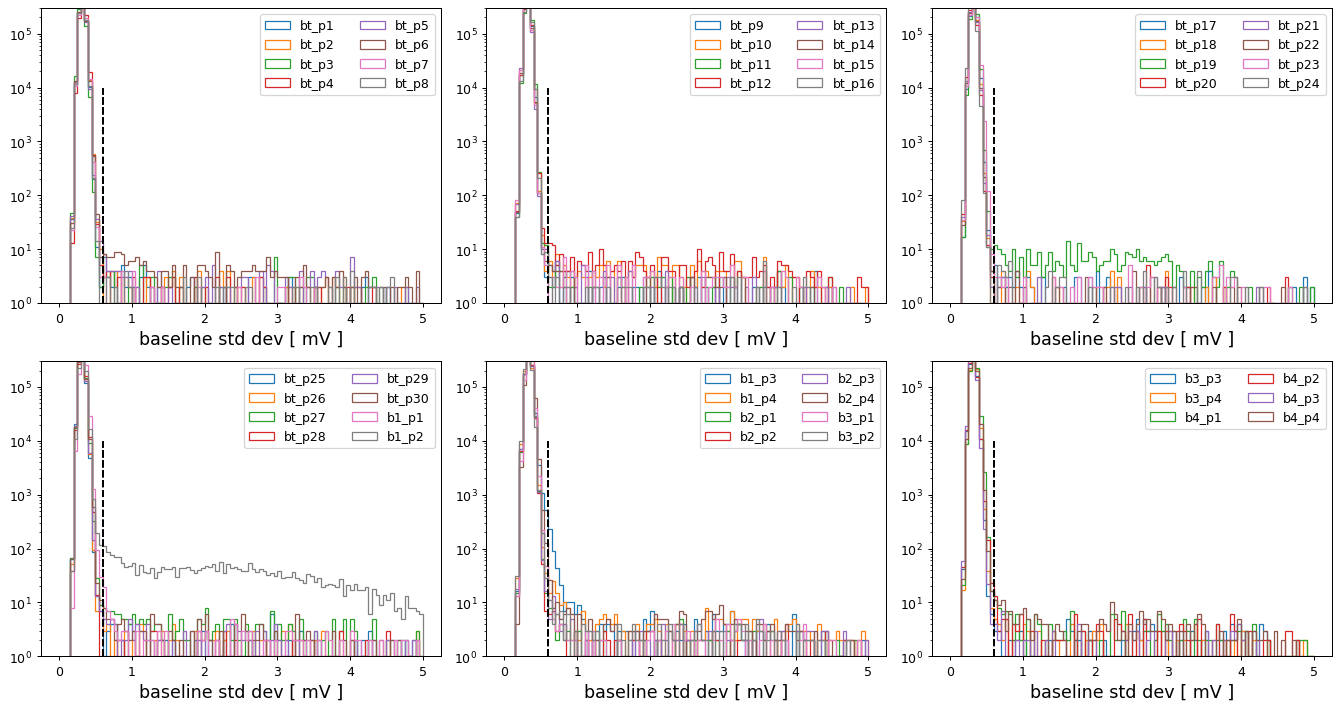

In [62]:
ncols = 3
nrows = 2
plt.figure(figsize=[5*ncols,4*nrows], dpi=90)

for i, chID in enumerate(ChID2PMTMap.keys()):
    c = i // 8
    ax = plt.subplot(nrows,ncols,c+1)
    plt.hist(std[chID], bins=100, range=(0, 5), histtype='step', 
             label=ChID2PMTMap[chID]);
    plt.vlines(0.6, 1, 1e4, color='k', linestyles='--')
    plt.legend(fontsize=10, ncol=2)
    plt.xlabel('baseline std dev [ mV ]', fontsize=14)
    plt.yscale('log')
    plt.ylim([1e0, 3e5])
plt.tight_layout()
plt.show()

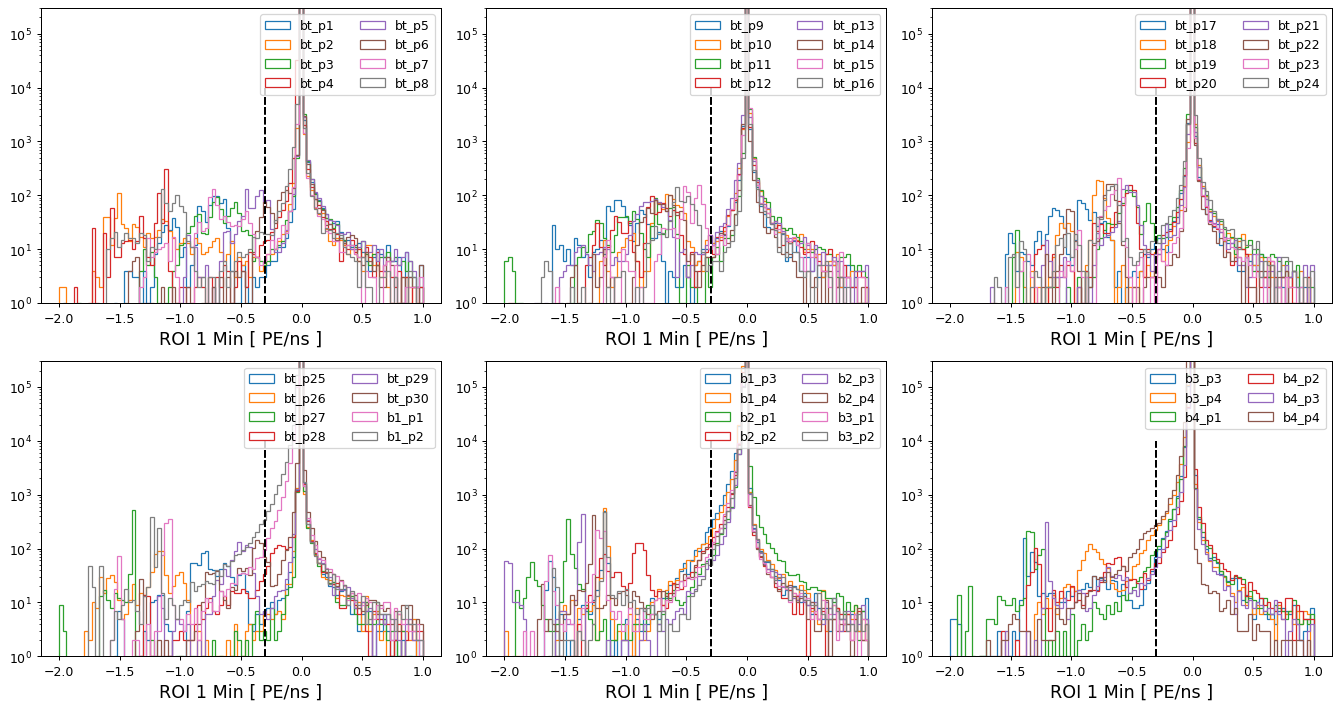

In [64]:


ncols = 3
nrows = 2
plt.figure(figsize=[5*ncols,4*nrows], dpi=90)

for i, chID in enumerate(ChID2PMTMap.keys()):
    c = i // 8
    ax = plt.subplot(nrows,ncols,c+1)
    plt.hist(low[chID], bins=100, range=(-2, 1), histtype='step', 
             label=ChID2PMTMap[chID]);
    plt.vlines([-0.3], 1, 1e4, color='k', linestyles='--')
    plt.legend(fontsize=10, ncol=2)
    plt.xlabel('ROI 1 Min [ PE/ns ]', fontsize=14)
    plt.yscale('log')
    plt.ylim([1e0, 3e5])
plt.tight_layout()
plt.show()


In [ ]:
plt.hist(std[106], bins=50, range=(0, 0.02), histtype='step', 
             label=ChID2PMTMap[106], color=my_colors[i%8]);
plt.yscale('log')


# Start muon chuck analysis

In [66]:
mu_rq_all = apply_muon_cuts(rq)

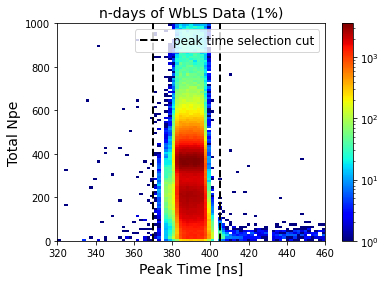

In [67]:
plt.figure()
pT_min = 370
pT_max = 405
h = plt.hist2d(mu_rq_all['peak_time'], mu_rq_all['area_sum'], bins=[75, 100], range=((320, 460), (0, 1000)), norm=colors.LogNorm(), cmap='jet');
plt.vlines([pT_min, pT_max], 0, 1e4, color='k', linestyle='--', linewidth=2, label='peak time selection cut')
plt.colorbar()
plt.xlabel('Peak Time [ns]', fontsize=14)
plt.ylabel('Total Npe', fontsize=14)
plt.title('n-days of WbLS Data (1%)')
plt.ylim([0, 1000])
plt.legend()
plt.show()

rChi2= 14.35478360487509 [4.90057176e+01 1.60403008e+01 2.09032448e+06]
rChi2= 1.8322529816869342 [8.95418651e+01 2.17702555e+01 1.14374738e+06]


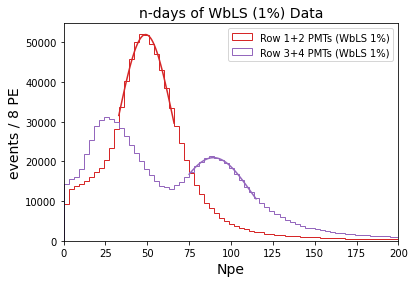

In [75]:
color_list=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
           'blue', 'limegreen', 'magenta', 'gray']
plot_crossing_muon=False
do_fit=True
# fit_range={
#     'row12': [60, 110],
#     'row34': [85, 125],
#     'bot': [250, 380]
# }
my_fit_range={
    'row12': [33, 66],
    'row34': [75, 115],
    'bot': [195, 255],
    'side': [130, 160],
    'sum': [360, 420],
}
plot_range=[0, 600]
nbinx=200

plt.figure()
time_mask= (mu_rq_all['peak_time']>=pT_min) & (mu_rq_all['peak_time']<pT_max)
# h = plt.hist(mu_rq_all['area_sum'][time_mask], bins=nbinx, range=plot_range, 
#          label='All PMTs (WbLS 1%)', histtype='step', color=color_list[0])
# h = plt.hist(mu_rq_all['area_bot'][time_mask], bins=nbinx, range=plot_range, 
#          label='Bot PMTs (WbLS 1%)',  histtype='step', color=color_list[1])
# h = plt.hist(mu_rq_all['area_side'][time_mask], bins=nbinx, range=plot_range,
#          label='Side PMTs (WbLS 1%)', histtype='step', color=color_list[2])
    
h=plt.hist(mu_rq_all['area_row12'][time_mask], bins=nbinx, range=plot_range, 
         label='Row 1+2 PMTs (WbLS 1%)', histtype='step', color=color_list[3])
if do_fit:
    fit_range=my_fit_range['row12']
    x = np.linspace(fit_range[0], fit_range[1], 100)
    res = fit_gauss(h, fit_range=fit_range, p0=[70, 10,100])
    y = gauss(x, res['popt'][0], res['popt'][1], res['popt'][2])
    print('rChi2=', res['chi2']/res['dof'], res['popt'])
    plt.plot(x, y, color=color_list[3])

h = plt.hist(mu_rq_all['area_row34'][time_mask], bins=nbinx, range=plot_range, 
         label='Row 3+4 PMTs (WbLS 1%)', histtype='step', color=color_list[4])
if do_fit:
    fit_range=my_fit_range['row34']
    x = np.linspace(fit_range[0], fit_range[1], 100)
    res = fit_gauss(h, fit_range=fit_range, p0=[100, 10,100])
    y = gauss(x, res['popt'][0], res['popt'][1], res['popt'][2])
    print('rChi2=', res['chi2']/res['dof'], res['popt'])
    plt.plot(x, y, color=color_list[4])
    
if plot_crossing_muon:
    plt.hist(mu_rq_all['area_row34_crx'], bins=nbinx, range=plot_range, color=color_list[4], alpha=0.4)
    plt.hist(mu_rq_all['area_row12_crx'], bins=nbinx, range=plot_range, color=color_list[3], alpha=0.4)
    plt.hist(mu_rq_all['area_side_crx'], bins=nbinx, range=plot_range, color=color_list[2], alpha=0.4)
    plt.hist(mu_rq_all['area_bot_crx'], bins=nbinx, range=plot_range,   color=color_list[1], alpha=0.4)
    plt.hist(mu_rq_all['area_sum_crx'], bins=nbinx, range=plot_range,  color=color_list[0], alpha=0.4)

plt.xlabel('Npe', fontsize=14)
if plot_crossing_muon:
    plt.yscale('log')
    plt.ylim([10, 1e5])
    
plt.legend(fontsize=10)
plt.xlim([0, 200])
# plt.ylim([0, 10000])

plt.ylabel('events / 8 PE',  fontsize=14)
plt.title('n-days of WbLS (1%) Data', fontsize=14)
plt.show()

221018 row12 13779 rchi2= 1.9743759109036931
221018 row34 13779 rchi2= 0.2672989332611292
221019 row12 42997 rchi2= 1.455245975072967
221019 row34 42997 rchi2= 1.1862707347427475
221020 row12 54624 rchi2= 1.4383817403082142
221020 row34 54624 rchi2= 0.5461777985575025
221022 row12 50346 rchi2= 1.801052716754977
221022 row34 50346 rchi2= 0.7330754987230761
221023 row12 34605 rchi2= 0.9504041456592284
221023 row34 34605 rchi2= 2.0156636600494626
221024 row12 19794 rchi2= 0.8582403162845739
221024 row34 19794 rchi2= 1.8140785961859154
221025 row12 38846 rchi2= 1.3049890591266444
221025 row34 38846 rchi2= 0.5728606146741552
221026 row12 33889 rchi2= 1.0959994449960269
221026 row34 33889 rchi2= 0.4840911360622981
221027 row12 57389 rchi2= 2.3149370603199477
221027 row34 57389 rchi2= 1.4145793870064407
221028 row12 26935 rchi2= 2.0511869516224244
221028 row34 26935 rchi2= 1.0240569955215277
221029 row12 49923 rchi2= 2.2110081365598186
221029 row34 49923 rchi2= 1.0678377709537406
221030 row12

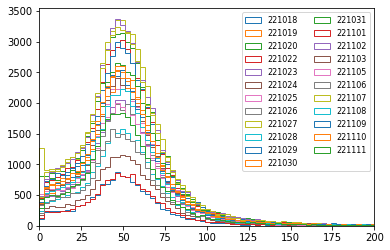

In [76]:
med = {'row12': [], 'row34': [], 'bot': [], 'side': [], 'sum': []}
mean = {'row12': [], 'row34': [], 'bot': [], 'side': [], 'sum': []}
width = {'row12': [], 'row34': [], 'bot': [], 'side': [], 'sum': []}
mean_err = {'row12': [], 'row34': [], 'bot': [], 'side': [], 'sum': []}
width_err = {'row12': [], 'row34': [], 'bot': [], 'side': [], 'sum': []}

date_list = list(path_dict.keys())
for i, rq in enumerate(rq_list):
    #dt = dt_list[i]
    date_str =date_list[i]
    mu_rq = apply_muon_cuts(rq)
    time_mask= (mu_rq['peak_time']>=pT_min) & (mu_rq['peak_time']<pT_max)
    
    # row 1+2
    fit_range=my_fit_range['row12']
    a = mu_rq['area_row12'][time_mask]
#     if len(a)<5000:
#         continue
    h = plt.hist(a, bins=nbinx, range=plot_range, histtype='step', label=date_str )
#     h = np.histogram(a, bins=nbinx, range=plot_range )
    p0_mu = (fit_range[0]+fit_range[1])/2
    res = fit_gauss(h, fit_range=fit_range, p0=[p0_mu, 10, 100])
    mean['row12'].append(res['popt'][0])
    mean_err['row12'].append(res['err'][0])
    width['row12'].append(res['popt'][1])
    width_err['row12'].append(res['err'][1])
    print(date_str, 'row12', len(a), 'rchi2=', res['chi2']/res['dof'])
    plt.xlim([0, 200])
    
    # row 3+4
    fit_range=my_fit_range['row34']
    a = mu_rq['area_row34'][time_mask]
#     h = plt.hist(a, bins=nbinx, range=plot_range, histtype='step', label=date_str )
    h = np.histogram(a, bins=nbinx, range=plot_range )
    p0_mu = (fit_range[0]+fit_range[1])/2
    res = fit_gauss(h, fit_range=fit_range, p0=[p0_mu, 10, 100])
    mean['row34'].append(res['popt'][0])
    mean_err['row34'].append(res['err'][0])
    width['row34'].append(res['popt'][1])
    width_err['row34'].append(res['err'][1])
    print(date_str, 'row34', len(a), 'rchi2=', res['chi2']/res['dof'])

    
plt.legend(ncol=2, fontsize=8)
#plt.show()

In [77]:
# import warnings
# import matplotlib.cbook
# warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# date_list = list(path_dict.keys())

# ncols = 2
# nrows = 2
# plt.figure(figsize=[5*ncols,4*nrows], dpi=90)
# for i, rq in enumerate(rq_list):
#     c = i // 8
#     ax = plt.subplot(nrows,ncols,c+1)
#     date_str =date_list[i]
#     mu_rq = apply_muon_cuts(rq)
#     time_mask= (mu_rq['peak_time']>=pT_min) & (mu_rq['peak_time']<pT_max)
    
#     # row 1+2
#     fit_range=my_fit_range['row12']
#     a = mu_rq['area_row12'][time_mask]
    
#     h = ax.hist(a, bins=nbinx, range=plot_range, histtype='step', label=date_str, color=color_list[i%8])
#     #h = plt.hist(a, bins=nbinx, range=plot_range, histtype='step', label=date_str )
    
#     p0_mu = (fit_range[0]+fit_range[1])/2
#     res = fit_gauss(h, fit_range=fit_range, p0=[p0_mu, 10, 100])
#     mean['row12'].append(res['popt'][0])
#     mean_err['row12'].append(res['err'][0])
#     width['row12'].append(res['popt'][1])
#     width_err['row12'].append(res['err'][1])
#     print(date_str, 'row12', len(a), 'rchi2=', res['chi2']/res['dof'])
#     x = np.linspace(fit_range[0], fit_range[1], 100)
#     y = gauss(x, res['popt'][0], res['popt'][1], res['popt'][2])
#     plt.plot(x, y, color= color_list[i%8])
#     ax.set_xlim([0, 200])
#     plt.legend()
#     plt.xlabel('Npe (Row 1+2)')
#     #plt.yscale('log')
# plt.tight_layout()
# plt.show()

In [78]:
# import numpy as np
# from iminuit import Minuit


# # define model and cost function
# def poly1(x, a, b):
#     return a+b*x


# def fit_linear(x, y, ye):
#     c = cost.LeastSquares(x, y, ye, poly1)
#     m = Minuit(c, a=0, b=0)
#     m.migrad()
#     m.hesse()


# # plot everything
# plt.errorbar(cx, d, derr, fmt="o", label="data", zorder=0)

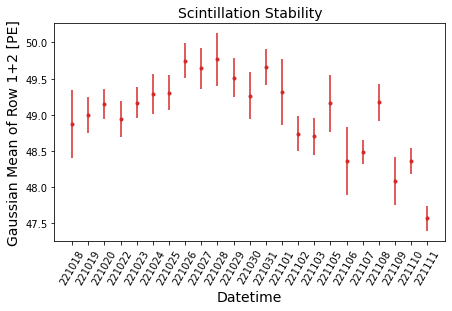

In [79]:
plt.figure(figsize=[7,4])
plt.errorbar(date_list, mean['row12'], yerr=mean_err['row12'], color='tab:red', 
           label='Row 1+2',  marker='.', linestyle = 'None')

# ts = np.array([dt.timestamp() for dt in date_list])
# ts=ts-ts[0]
# print(ts)
plt.xticks(rotation=60)
plt.title('Scintillation Stability')
plt.ylabel('Gaussian Mean of Row 1+2 [PE]')
plt.xlabel('Datetime')
# plt.ylim([55, 65])
plt.show()

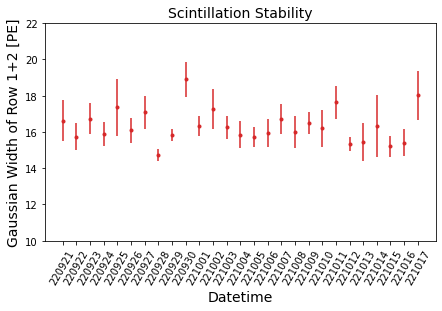

In [257]:
plt.figure(figsize=[7,4])
plt.errorbar(date_list, width['row12'], yerr=width_err['row12'], color='tab:red', 
           label='Row 1+2',  marker='.', linestyle = 'None')

# ts = np.array([dt.timestamp() for dt in date_list])
# ts=ts-ts[0]
# print(ts)
plt.xticks(rotation=60)
plt.title('Scintillation Stability')
plt.ylabel('Gaussian Width of Row 1+2 [PE]')
plt.xlabel('Datetime')
plt.ylim([10, 22])
plt.show()

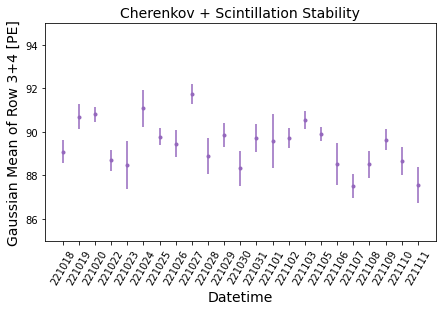

In [44]:
plt.figure(figsize=[7,4])
plt.errorbar(date_list, mean['row34'], yerr=mean_err['row34'], color='tab:purple', 
           label='Row 3+4',  marker='.', linestyle = 'None')
plt.xticks(rotation=60)
plt.title('Cherenkov + Scintillation Stability')
plt.ylabel('Gaussian Mean of Row 3+4 [PE]')
plt.xlabel('Datetime')
plt.ylim([85, 95])
plt.show()

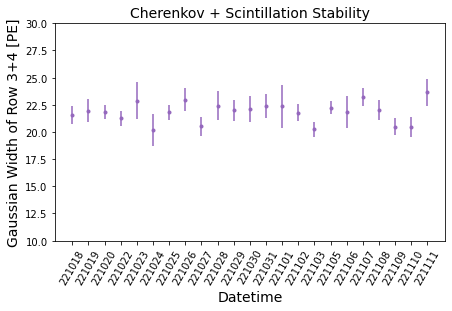

In [45]:
plt.figure(figsize=[7,4])
plt.errorbar(date_list, width['row34'], yerr=width_err['row34'], color='tab:purple', 
           label='Row 3+4',  marker='.', linestyle = 'None')
plt.xticks(rotation=60)
plt.title('Cherenkov + Scintillation Stability')
plt.ylabel('Gaussian Width of Row 3+4 [PE]')
plt.xlabel('Datetime')
plt.ylim([10, 30])
plt.show()

area_sum: rChi2= 0.6614436090936074 [3.87087615e+02 4.56487584e+01 8.79433225e+05]
area_bot: rChi2= 1.7816127541791162 [2.20158762e+02 3.88613274e+01 9.41757353e+05]
area_side: rChi2= 0.8298569532755339 [1.59788516e+02 2.43669894e+01 9.33322868e+05]


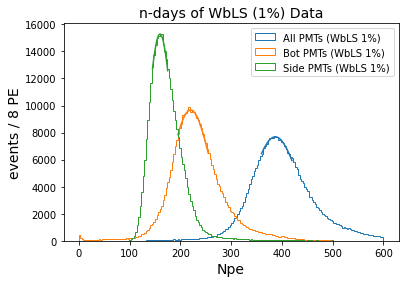

In [52]:
row34_mask = (mu_rq_all['area_row34']>=65) &  (mu_rq_all['area_row34']<140)

do_fit=True

plt.figure()
time_mask= (mu_rq_all['peak_time']>=pT_min) & (mu_rq_all['peak_time']<pT_max)
mask = (time_mask) & (row34_mask)


h = plt.hist(mu_rq_all['area_sum'][mask], bins=nbinx, range=plot_range, 
         label='All PMTs (WbLS 1%)', histtype='step', color=color_list[0])
if do_fit:
    fit_range=my_fit_range['sum']
    x = np.linspace(fit_range[0], fit_range[1], 100)
    p0_guess = (fit_range[0] + fit_range[1])/2
    res = fit_gauss(h, fit_range=fit_range, p0=[p0_guess, 10,100])
    y = gauss(x, res['popt'][0], res['popt'][1], res['popt'][2])
#     res = fit_crystalball(h, fit_range=fit_range, p0=[200, 20, -0.5, 5, 1000])
#     y = crystalball(x, res['popt'][0], res['popt'][1], res['popt'][2], res['popt'][3], res['popt'][4])
    print('area_sum:', 'rChi2=', res['chi2']/res['dof'], res['popt'])
    plt.plot(x, y, color=color_list[0])
    
    
h = plt.hist(mu_rq_all['area_bot'][mask], bins=nbinx, range=plot_range, 
         label='Bot PMTs (WbLS 1%)',  histtype='step', color=color_list[1])
if do_fit:
    fit_range=my_fit_range['bot']
    x = np.linspace(fit_range[0], fit_range[1], 100)
    res = fit_gauss(h, fit_range=fit_range, p0=[300, 30,100])
    y = gauss(x, res['popt'][0], res['popt'][1], res['popt'][2])
#     res = fit_crystalball(h, fit_range=fit_range, p0=[310, 20, -0.5, 10, 1000])
#     y = crystalball(x, res['popt'][0], res['popt'][1], res['popt'][2], res['popt'][3], res['popt'][4])
    print('area_bot:', 'rChi2=', res['chi2']/res['dof'], res['popt'])
    plt.plot(x, y, color=color_list[1])
    
h = plt.hist(mu_rq_all['area_side'][mask], bins=nbinx, range=plot_range,
         label='Side PMTs (WbLS 1%)', histtype='step', color=color_list[2])
if do_fit:
    fit_range=my_fit_range['side']
    x = np.linspace(fit_range[0], fit_range[1], 100)
    res = fit_gauss(h, fit_range=fit_range, p0=[150, 10,100])
    y = gauss(x, res['popt'][0], res['popt'][1], res['popt'][2])
#     res = fit_crystalball(h, fit_range=fit_range, p0=[200, 20, -0.5, 5, 1000])
#     y = crystalball(x, res['popt'][0], res['popt'][1], res['popt'][2], res['popt'][3], res['popt'][4])
    print('area_side:', 'rChi2=', res['chi2']/res['dof'], res['popt'])
    plt.plot(x, y, color=color_list[2])
    
# h=plt.hist(mu_rq_all['area_row12'][time_mask], bins=nbinx, range=plot_range, 
#          label='Row 1+2 PMTs (WbLS 1%)', histtype='step', color=color_list[3])
# h = plt.hist(mu_rq_all['area_row34'][time_mask], bins=nbinx, range=plot_range, 
#          label='Row 3+4 PMTs (WbLS 1%)', histtype='step', color=color_list[4])
    
plt.xlabel('Npe', fontsize=14)
# plt.yscale('log')
plt.legend(fontsize=10)
plt.ylabel('events / 8 PE',  fontsize=14)
plt.title('n-days of WbLS (1%) Data', fontsize=14)
plt.show()

In [53]:
date_list = list(path_dict.keys())
for i, rq in enumerate(rq_list):
    #dt = dt_list[i]
    date_str =date_list[i]
    mu_rq = apply_muon_cuts(rq)
    time_mask= (mu_rq['peak_time']>=pT_min) & (mu_rq['peak_time']<pT_max)
    row12_mask = mu_rq['area_bot']>70
    
    fit_range=my_fit_range['bot']
    a = mu_rq['area_bot'][(time_mask) & (row12_mask)]
#     h = plt.hist(a, bins=nbinx, range=plot_range, histtype='step', label=date_str )
    h = np.histogram(a, bins=nbinx, range=plot_range )
    p0_mu = (fit_range[0]+fit_range[1])/2
    res = fit_gauss(h, fit_range=fit_range, p0=[p0_mu, 10, 100])
    mean['bot'].append(res['popt'][0])
    mean_err['bot'].append(res['err'][0])
    width['bot'].append(res['popt'][1])
    width_err['bot'].append(res['err'][1])
    print(date_str, 'bot', len(a), 'rchi2=', res['chi2']/res['dof'])
    
    fit_range=my_fit_range['side']
    a = mu_rq['area_side'][(time_mask) & (row12_mask)]
    h = np.histogram(a, bins=nbinx, range=plot_range )
    p0_mu = (fit_range[0]+fit_range[1])/2
    res = fit_gauss(h, fit_range=fit_range, p0=[p0_mu, 10, 100])
    mean['side'].append(res['popt'][0])
    mean_err['side'].append(res['err'][0])
    width['side'].append(res['popt'][1])
    width_err['side'].append(res['err'][1])
    print(date_str, 'side', len(a), 'rchi2=', res['chi2']/res['dof'])

    
    fit_range=my_fit_range['sum']
    a = mu_rq['area_sum'][(time_mask) & (row12_mask)]
    h = np.histogram(a, bins=nbinx, range=plot_range )
    p0_mu = (fit_range[0]+fit_range[1])/2
    res = fit_gauss(h, fit_range=fit_range, p0=[p0_mu, 10, 100])
    mean['sum'].append(res['popt'][0])
    mean_err['sum'].append(res['err'][0])
    width['sum'].append(res['popt'][1])
    width_err['sum'].append(res['err'][1])
    print(date_str, 'sum', len(a), 'rchi2=', res['chi2']/res['dof'])
#plt.legend()
#plt.show()

221018 bot 11182 rchi2= 0.8410497329550364
221018 side 11182 rchi2= 0.8356664227699172
221018 sum 11182 rchi2= 0.8538368152505933
221019 bot 35053 rchi2= 1.8913754559784235
221019 side 35053 rchi2= 0.3143098139129976
221019 sum 35053 rchi2= 0.8816536809189854
221020 bot 44068 rchi2= 0.7140117735452434
221020 side 44068 rchi2= 0.3940511708421261
221020 sum 44068 rchi2= 1.2847322282889906
221022 bot 41128 rchi2= 0.5662398204445588
221022 side 41128 rchi2= 0.6574379219885098
221022 sum 41128 rchi2= 0.6214203693318666
221023 bot 28234 rchi2= 0.8894784534294856
221023 side 28234 rchi2= 0.9951679375917067
221023 sum 28234 rchi2= 0.9047687820824469
221024 bot 16131 rchi2= 1.0522235168929783
221024 side 16131 rchi2= 0.4919492868067281
221024 sum 16131 rchi2= 1.4023738001083794
221025 bot 31629 rchi2= 2.4355352760147357
221025 side 31629 rchi2= 0.9422937120346463
221025 sum 31629 rchi2= 1.1937955667622624
221026 bot 27569 rchi2= 0.611820278455961
221026 side 27569 rchi2= 1.7886917934338653
2210

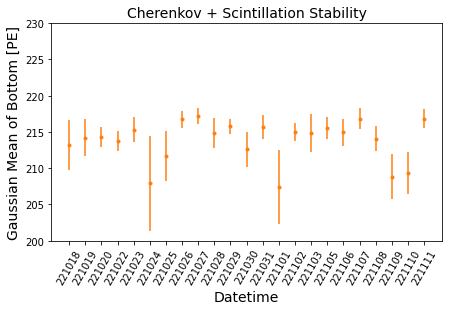

In [54]:
plt.figure(figsize=[7,4])
plt.errorbar(date_list, mean['bot'], yerr=mean_err['bot'], color='tab:orange', 
           label='Bottom',  marker='.', linestyle = 'None')
plt.xticks(rotation=60)
plt.title('Cherenkov + Scintillation Stability')
plt.ylabel('Gaussian Mean of Bottom [PE]')
plt.xlabel('Datetime')
plt.ylim([200, 230])
plt.show()

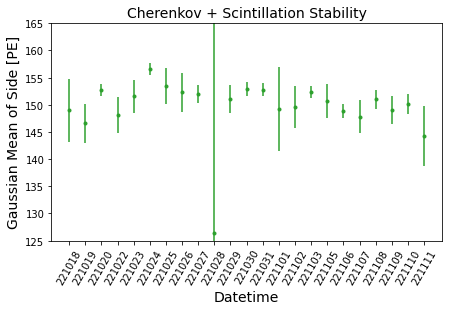

In [57]:
plt.figure(figsize=[7,4])
plt.errorbar(date_list, mean['side'], yerr=mean_err['side'], color='tab:green', 
           label='Side',  marker='.', linestyle = 'None')
plt.xticks(rotation=60)
plt.title('Cherenkov + Scintillation Stability')
plt.ylabel('Gaussian Mean of Side [PE]')
plt.xlabel('Datetime')
plt.ylim([125, 165])
plt.show()

In [42]:
date_list

['221018',
 '221019',
 '221020',
 '221022',
 '221023',
 '221024',
 '221025',
 '221026',
 '221027',
 '221028',
 '221029',
 '221030',
 '221031',
 '221101',
 '221102',
 '221103',
 '221105',
 '221106',
 '221107',
 '221108']

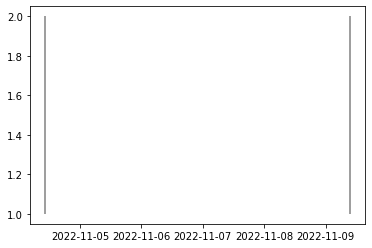

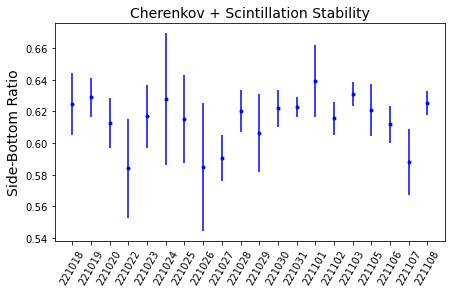

In [17]:
# side-to-bot ratio
plt.figure(figsize=[7,4])

frac_err_bot = np.array(mean_err['bot'])/ np.array(mean['bot'])
frac_err_side = np.array(mean_err['side']) / np.array(mean['side'])
sb_err = np.sqrt(np.square(frac_err_bot) + np.square(frac_err_side))
sb = np.array(mean['side'])/np.array(mean['bot'])
sb_err = sb_err*sb

plt.errorbar(date_list, sb, yerr=sb_err, color='b', 
           label='Bottom',  marker='.', linestyle = 'None')
plt.xticks(rotation=60)
plt.title('Cherenkov + Scintillation Stability')
plt.ylabel('Side-Bottom Ratio')
#plt.xlabel('Datetime')
#plt.ylim([95, 110])
plt.show()


425.35327


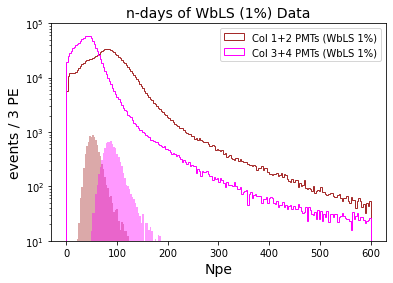

In [160]:
color_list=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
           'brown', 'magenta']
plot_crossing_muon=True
do_fit=False

my_fit_range={
    'col12': [45, 70],
    'col34': [75, 115],
}
plot_range=[0, 600]
nbinx=200

plt.figure()
time_mask= (mu_rq_all['peak_time']>=pT_min) & (mu_rq_all['peak_time']<pT_max)

    
h=plt.hist(mu_rq_all['area_col12'][time_mask], bins=nbinx, range=plot_range, 
         label='Col 1+2 PMTs (WbLS 1%)', histtype='step', color=color_list[5])
if do_fit:
    fit_range=my_fit_range['col12']
    x = np.linspace(fit_range[0], fit_range[1], 100)
    res = fit_gauss(h, fit_range=fit_range, p0=[70, 10,100])
    y = gauss(x, res['popt'][0], res['popt'][1], res['popt'][2])
    print('rChi2=', res['chi2']/res['dof'], res['popt'])
    plt.plot(x, y, color=color_list[5])

h = plt.hist(mu_rq_all['area_col34'][time_mask], bins=nbinx, range=plot_range, 
         label='Col 3+4 PMTs (WbLS 1%)', histtype='step', color=color_list[6])
if do_fit:
    fit_range=my_fit_range['col34']
    x = np.linspace(fit_range[0], fit_range[1], 100)
    res = fit_gauss(h, fit_range=fit_range, p0=[100, 10,100])
    y = gauss(x, res['popt'][0], res['popt'][1], res['popt'][2])
    print('rChi2=', res['chi2']/res['dof'], res['popt'])
    plt.plot(x, y, color=color_list[6])
    
if plot_crossing_muon:
    plt.hist(mu_rq_all['area_col34_crx'], bins=nbinx, range=plot_range, color=color_list[5], alpha=0.4)
    plt.hist(mu_rq_all['area_col12_crx'], bins=nbinx, range=plot_range, color=color_list[6], alpha=0.4)


plt.xlabel('Npe', fontsize=14)
if plot_crossing_muon:
    plt.yscale('log')
    plt.ylim([10, 1e5])
    
plt.legend(fontsize=10)
# plt.xlim([0, 400])
# plt.ylim([0, 10000])

plt.ylabel('events / 3 PE',  fontsize=14)
plt.title('n-days of WbLS (1%) Data', fontsize=14)
plt.show()

In [167]:
path_list = make_file_paths('../data/rq/v1.0.2d/', data_file)
path_dict = group_by_n_files(path_list, n_files=9)
f= uproot.open(path_list[0])
var_names = []
for k in f['event'].keys():
    if k[0:3] == 'ch_':
        continue
    var_names.append(k)

In [168]:
mean_crx = {'col12':[], 'col34': []}
width_crx = {'col12':[], 'col34': []}
mean_err_crx = {'col12':[], 'col34': []}

date_list = list(path_dict.keys())
for i, p in path_dict.items():
    date_str =i
    rq = get_concatenated_data(p, var_names=var_names)
    mu_rq = apply_muon_cuts(rq)

    a = mu_rq['area_col12_crx']
    a=a[a<200]
    mean_crx['col12'].append(np.median(a))
    mean_err_crx['col12'].append(np.std(a)/np.sqrt(len(a)))
    print(date_str, 'col12', len(a))
   
    a = mu_rq['area_col34_crx']
    a=a[a<200]
    mean_crx['col34'].append(np.median(a))
    mean_err_crx['col34'].append(np.std(a)/np.sqrt(len(a)))
    print(date_str, 'col34', len(a))


220921 col12 793
220921 col34 805
220923 col12 1049
220923 col34 1070
220927 col12 965
220927 col34 979
220930 col12 842
220930 col34 857
221002 col12 737
221002 col34 754
221005 col12 1006
221005 col34 1031
221008 col12 952
221008 col34 979
221011 col12 1160
221011 col34 1182
221014 col12 1150
221014 col34 1171


Text(0, 0.5, 'Median Npe of Column 1+2')

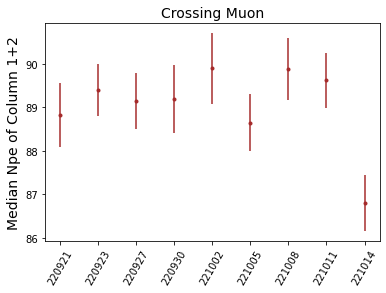

In [169]:
plt.errorbar(date_list, mean_crx['col12'], yerr=mean_err_crx['col12'], color=color_list[5], 
           label='Col 1+2',  marker='.', linestyle = 'None')
plt.xticks(rotation=60)
plt.title('Crossing Muon')
plt.ylabel('Median Npe of Column 1+2')

Text(0, 0.5, 'Median Npe of Column 3+4')

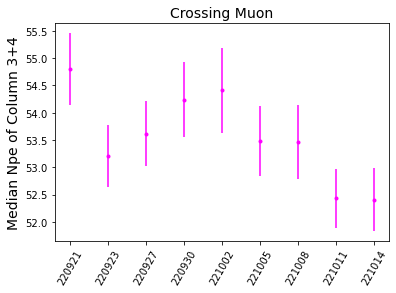

In [175]:
plt.errorbar(date_list, mean_crx['col34'], yerr=mean_err_crx['col34'], color=color_list[6], 
           label='Col 3+4',  marker='.', linestyle = 'None')
plt.xticks(rotation=60)
plt.title('Crossing Muon')
plt.ylabel('Median Npe of Column 3+4')

Text(0, 0.5, 'Median Npe of Column 3+4')

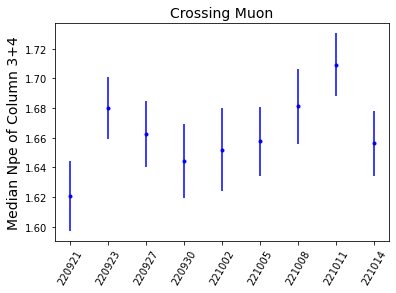

In [174]:
r = np.array(mean_crx['col12']) / np.array(mean_crx['col34'])
frac_err_12 = np.array(mean_err_crx['col12'])/ np.array(mean_crx['col12'])
frac_err_34 = np.array(mean_err_crx['col34']) / np.array(mean_crx['col34'])
r_err = np.sqrt(np.square(frac_err_12) + np.square(frac_err_34))
r_err = r_err*r

plt.errorbar(date_list, r, yerr=r_err, color='b', 
          marker='.', linestyle = 'None')
plt.xticks(rotation=60)
plt.title('Crossing Muon')
plt.ylabel('Ratio: (C1+C2)/(C3+C4)')